## **Per-Patch Classification: Xception based Classifier**
This notebook considers training and visualization of the per-patch classifier based on the Xception model.




In [ ]:
    try: # Google Colab integration
        from google.colab import drive

        print('Colab environment detected. Mounting drive...')
        drive.mount('/content/drive')

        print('Mounted. Switching to directory... ', end = '')
        %cd /content/drive/'My Drive'/CILroadseg
        print('done.')
    except:
        print('Colab environment not found. Working on ordinary directory.')

Colab environment detected. Mounting drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted. Switching to directory... /content/drive/My Drive/CILroadseg
done.


In [ ]:
import numpy as np
import sys
import os
import matplotlib.image as mpimg

from util.helpers import *
from util.cross_validation import cross_validate
from util.submit import *      # util/submit.py contains the functions used to generate the CSV file for Kaggle Competition
from util.visualize import *   # util/visualize.py provides functions for image visualization
from util.notebooks import *   # util/notebooks.py contains various util functions used in notebooks

# **Loading Training Data**
`nb_load_data` is an helper function provided in `util/notebooks.py`

In [ ]:
train_dir = "training/images_additionaldata/"
gt_dir = "training/groundtruth_additionaldata/"
test_dir = "test/images/"

X, Y, X_test = nb_load_data(train_dir, gt_dir, test_dir)
Y = (Y >= 0.25) * 1

Loading training input...
Progress: done (148 images).
Loading training groundtruth...
Progress: done (148 images).
Loading test input...
Progress: done (94 images).

       Training data shape: (148, 400, 400, 3)
Training groundtruth shape: (148, 400, 400)
           Test data shape: (94, 608, 608, 3)


# **Working with the Model**
The `XceptionModel` and `Decomposer` class is a subclass of ModelBase. This base class can be found in `util/model_base.py` and provides a common interface to all the models we created.

In particular:

`initialize()` resets the state of the object and should be called before the 

*   `initialize()` resets the state of the object and should be called before the training starts
*   `train(Y, X)` takes the training data X and its groundtruth Y to train the model
*   `classify(X)` returns the predictions for X
*   `load(filename)` and `save(filename)` load and save weights of the Neural Network from file.

The `Decomposer` class is a decorator which performs bootstrapping and data augmentation for all the per-patch classifiers (in this case `XceptionModel`).

The `Discretizer` decorator transforms the output of the inner model from [0, 1] to {0, 1} rounding to either 0 or 1 based on the given threshold.

One can allocate a model like below.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from naive_cnn_model import *
from decomposer import *
from recomposer import *
from discretize import * 
from xception_model import *
from rotate_vote import * 
keras.__version__

Using TensorFlow backend.


'2.3.0-tf'

In [ ]:
#model = Decomposer(Xception_Model()) 
model = Decomposer(RotAndVote(Xception_Model(), method='avg'), window_size = 200)
model = Discretizer(model, threshold = 0.5)

model.initialize()


83689472/83683744 [==============================] - 1s 0us/step
create xcept model
created xcept model successfully
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Tot

In [ ]:
choice = 'load'

np.random.seed(1) #fix randomness
if choice == 'cv':
  cross_validate(model, 10, X, Y)

elif choice == 'tr':
  model.initialize()
  model.train(Y, X) 

else:
  model.load("saves/final/xception_bnotsplit.h5")

# **Model Saving**

In [ ]:
weights_file = "saves/final/xception_bnotsplit.h5"

nb_save_model(model, weights_file)

[Target file: saves/final/xception_baseline.h5]
Saving model to disk...done.


# **Making Predictions with the Model**
`Decomposer.classify(X)` decomposes the images of X into windows and then calls `XceptionModel.classify(X)` to do the patchwise classification, but it does not recompose the images. This is true for all the patchwise classifiers we created, because having patchwise predictions can be useful in certain cases.

If you want the model to return full masks, you need to wrap it into a `Recomposer` decorator, as below. The implementation of this decorator class can be found in `recomposer.py.`

In [ ]:
test_masks_dir = "test/pred/"
test_dir = "test/images/"

model = Recomposer(model)
nb_predict_masks(model, test_dir, test_masks_dir)

Predicting test cases... 
Progress: done.


In [ ]:
image_paths = [test_masks_dir + file for file in os.listdir(test_masks_dir)]

masks_to_submission("test/csv/xception_bnotsplit_2.csv", image_paths)

# **Visualizing predictions**
The function view_image_array is provided in `util/visualize.py`. It uses `matplotlib` to visualize the images and the corresponding predictions.

In [ ]:
Y_pred = model.classify(X_test[0:10])

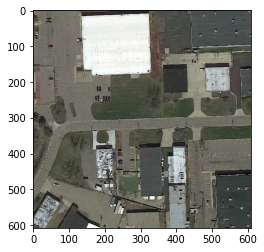

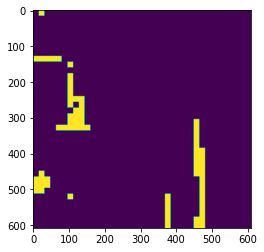

In [ ]:
view_image_mask(X_test[1], Y_pred[1])